# Lecture 2
### Programming neuronal network object orientated.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class net:
    ''' class to hold a neuronal net. 
    It is not intended that number of layers and/or neurons changes in object of this class.
    Parameter neurons defines number of neurons in each layer (incl. input and output layer). 
    Parameter neurons should be passed as list object of integers.
    Parameter activations holds activations for each layer, needs to be list object with one
    element less than neurons. Activations are strings: 'linear', 'jump', 'ReLU', 'sigmoid'.
    Variables y_layers and df_layers are intended to hold status (value and derivative f'(z)) 
    of all neurons for backprop'''
    def __init__(self, neurons, activations):
        # Checking if net is well defined
        if (len(neurons) - 1) != len(activations): 
            # throw error, if net is bad defiend. TO BE IMPLEMENTED
            raise ValueError('Number of activations mismatches number of layers')
        # Creating biases vectors as a list of 1D numpy arrays
        # Creating weights matrices as a list of 2D numpy arrays
        self.b = []
        self.w = []
        # Creating matrices to store gradient of biasas as a list of 1D numpy arrays
        self.db = []
        # Creating matrices to store gradient of weights as a list of 2D numpy arrays
        self.dw = []
        for i, n_layer in enumerate(neurons[1:]):
            n_previous_layer = neurons[i] # i runs from 0 to len(neurons) - 1
            # Creating biases with arbitary values uniformly distributed from -1 to 1
            self.b.append(np.random.uniform(low=-1, high=1, size=(n_layer)))
            # Creating corresponding list of 1D arrays to store gradient of biases
            self.db.append(np.zeros(shape=n_layer))
            # Creating weights with arbitary values uniformly distributed from -1 to 1
            # Transposed to match matrix multiplication y @ w later (this is for handling 
            # batches of input data simultaniously)
            self.w.append((np.random.uniform(low=-1, high=1, size=(n_layer, n_previous_layer))).T)
            # Initializing corresponding list of matrices intended to hold gradients dw of weights w
            self.dw.append(np.zeros(shape=(n_layer, n_previous_layer)))
        # Defining activations
        self.a = activations
        # Defining list of empty lists as storage for values y=f(z) of neurons, as well as derivative
        # f'(z) of neurons.
        self.y_layers = [[] for i in range(len(neurons))] # as many entrys in y_layers as layers of nerons
        self.df_layers = [[] for i in range(len(neurons))] # one less entrys in df_layers as layers in net,
                                                              # because input layer's derivative is undefined.
                                                              # However index is chosen same as for y_layer, to
                                                              # avoid index shift between these. Position 
                                                              # df_layers[0] will stay unused
    
#    def apply_factor_to_weights(self, factor):
#        ''' Gives possibilty to factorize initial weights'''
#        self.w = [factor*x for x in self.w]
        
    def apply_factor_to_weights(self, factor):
        ''' Gives possibilty to factorize initial weights'''
        for i, value in enumerate(self.w):
            self.w[i] *= factor
  
    def apply_factor_to_biases(self, factor):
        for i, value in enumerate(self.b):
            self.b[i] *= factor
        
    def __net_f_df__(self, z, activation):
        '''Returns value for activation of f(z) and its derivative f'(z)
        '''
        if activation == 'sigmoid':
            return([1/(1+np.exp(-z)), 
                1/((1+np.exp(-z))*(1+np.exp(z)))])
        elif activation == 'jump': # cheating a bit here: replacing f'(z)=delta(z) by something smooth
            return([np.array(z>0,dtype='float'), 
                10.0/((1+np.exp(-10*z))*(1+np.exp(10*z))) ] )
        elif activation == 'ReLU':
            return([(z>0)*z, (z>0)*1.0])
        elif activation == 'linear':
            return([z, np.ones(shape=z.shape)])
    
    def __apply_forward_step__(self, y_in, n):
        ''' Performs forward calculation step from one layer to next.
        n is index of calculated layer'''
        z = (y_in @ self.w[n-1]) + self.b[n-1]
        return(self.__net_f_df__(z, self.a[n-1]))
    
    def apply_net(self, y_in):
        '''One forwards loop through the net, returning output neuron's values.
        y_in must provide input neuron's values. Keeping values necessary for backprop '''
        self.y_layers[0] = y_in.copy() # copy, to exclude interference of class with source of input
        for i in range(len(self.w)):
            self.y_layers[i+1], self.df_layers[i+1] = self.__apply_forward_step__(self.y_layers[i], i+1)
        return(self.y_layers[-1]) # Returning last element of y gives output layer values to caller
    
    def apply_net_simple(self, y_in):
        '''Simple forward loop trough net to obtain output. Without keeping values for backprop.'''
        y = y_in.copy() # Copy of input neurons values, to not interfere with caller
        for i in range(len(self.w)):
            y = self. __apply_forward_step__(y, i+1)[0] # Keep only y-values, dumping derivitave f'(z)
        return(y) # Returning output neuron's values
    
    def __backprop_step__(self, delta, n):
        '''Takes delta-vector of layer n and returns delta-vector vor layer n-1. Index of layer "n" must
        explicitly passed'''
        return delta @ (self.w[n].T) * self.df_layers[n]
    
    def __backprop__(self, y_target):
        ''' Performs backpropagation of net with given batch of target values. Adjustes weights and biases'''
        # Calculating batchsize for averaging
        batchsize = y_target.shape[0]
        # Calculating first vector delta from value of output neurons compared with target values and f'(z) 
        # of output layer
        delta = (self.y_layers[-1] - y_target) * self.df_layers[-1]
        # Calculating gradients of cost function from delta vector
        self.dw[-1] = self.y_layers[-2].T @ delta / batchsize # Averaging over samples in batch necessary. Trans-
        # pose of y_layers necessary, so matrix product sums over neurons not batchsize
        self.db[-1] = delta.sum(0) / batchsize # Averaging over samples in batch necessary
        # Loop to calculate gradient of all remaining weight matrices
        for i in reversed(range(len(self.y_layers)-2)):
            # calculate updated delta (one step backwards into net)
            delta = self.__backprop_step__(delta, i+1) #delta = delta @ (self.w[i] * self.df_layers[i])
            # From delta calculate gradient of weights and average over batchsize
            self.dw[i] = ((self.y_layers[i].T) @ delta) / batchsize
            # From delta calculate gradients of biases and average over batchsize
            self.db[i] = delta.sum(0) / batchsize
            
    def __gradient_step__(self, eta):
        # Updating weights by substracting gradient dw times learning rate eta
        for i in range(len(self.w)):
            self.w[i] -= eta * self.dw[i]
        # Updating biases by substracting gradient db times learning rate eta
        for i in range(len(self.b)):
            self.b[i] -= eta * self.db[i]
            
    def train_net(self, y_in, y_target, eta):
        if len(y_target.shape) == 1:
            y_target = y_target[:, np.newaxis]
        # Apply net to obtain output as of current state of net
        y_out = self.apply_net(y_in)
        # Perform backpropagation algorithm to obtain gradients for weights and biases
        self.__backprop__(y_target)
        # Calculate new weights and biases from result of backpropagation
        self.__gradient_step__(eta)
        # Return cost function
        return(0.5*((y_out - y_target)**2).sum() / y_in.shape[0])


## Demonstrating learning capability of programmed class

In [26]:
a = net(neurons=[2, 5, 4, 1], activations=['ReLU', 'ReLU', 'ReLU'])

array([-1.13681951,  0.03628172, -0.44632999,  2.90835398])

In [19]:
for i in range(20):
    a.train_net(y_in=np.array([[-2, 1]]), y_target=np.array([5]), eta=.01)

In [20]:
a.apply_net_simple(y_in=np.array([[-2, 1]]))

array([[-0.]])

In [21]:
c = net(neurons=[2, 10, 10, 1], activations=['sigmoid', 'ReLU', 'linear'])

In [22]:
for i in range(50):
    c.train_net(y_in=np.array([[-2, 1], [-1, 3], [4, 4]]), y_target=np.array([1, -1, -1.5]), eta=.1)

In [23]:
c.y_layers[-1]

array([[ 0.82112369],
       [-0.67718875],
       [-1.66223731]])

## Learning an simple image

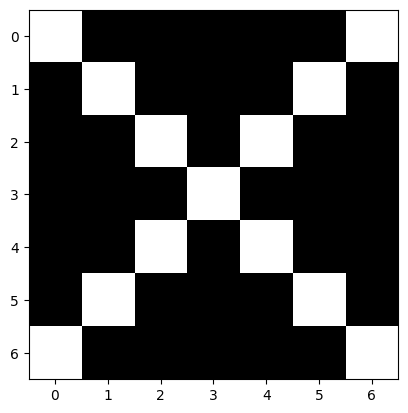

In [3]:
# Defining image as binary mask
target = np.diag(v=np.array([1, 1, 1, 1, 1, 1, 1]))
for i in range(target.shape[1]):
    target[target.shape[1] - i - 1, i] = 1
plt.imshow(target, cmap='gray')

In [27]:
# Defining neuronal network
image_net = net(neurons=[2, 75, 75, 75, 1], activations=['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'])

In [138]:
# Multible application of stochastic gradient descent
for i in range(5000 - 1):
    # Extracting samples from target image
    batchsize = 15
    samples = np.zeros(shape=(batchsize, 3))
    # Taking arbitary values from traget-image to set up traing batch
    for i in range(batchsize):
        coord1 = np.random.randint(low=0, high=target.shape[0])
        coord2 = np.random.randint(low=0, high=target.shape[1])
        samples[i, 0] = coord1
        samples[i, 1] = coord2
        samples[i, 2] = target[coord1, coord2]

    # Learning one cycle on sample
    image_net.train_net(y_in=samples[:, :-1], y_target=samples[:, 2].flatten(), eta=0.01)
# Printing last value of cost function to screen
print(image_net.train_net(y_in=samples[:, :-1], y_target=samples[:, 2].flatten(), eta=0.01))

0.0006903425266766255


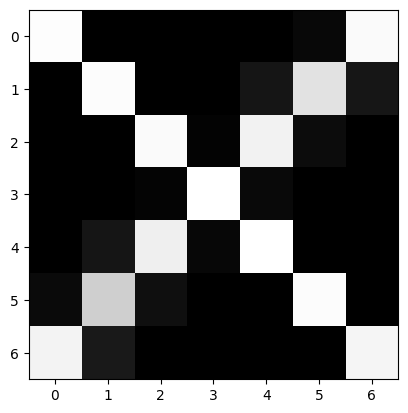

In [139]:
# Plot resulting image of net after learning

axes = (np.ogrid[0:target.shape[1], 0:target.shape[0]])
grid = np.meshgrid(axes[0], axes[1])
image_index = np.concatenate([grid[1].flatten()[:, np.newaxis], grid[0].flatten()[:, np.newaxis]], axis=1)
image_learned = image_net.apply_net_simple(y_in=image_index)
plt.imshow(image_learned.reshape(target.shape), cmap='gray')

## Performing some statistics on weights and biases

In [150]:
image_net.w[0].std()

1.0268238034361166

In [151]:
image_net.w[0].mean()

0.08939795327656536

In [144]:
image_net.b[2].std()

0.5749095365833058

In [145]:
image_net.b[2].mean()

0.022042619801323656